In [9553]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
from scipy.interpolate import make_interp_spline, BSpline, interp1d, pchip, InterpolatedUnivariateSpline
from matplotlib.patches import FancyArrowPatch, PathPatch
from matplotlib.path import Path
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit, minimize_scalar
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from sympy import symbols, Eq, solve
from uncertainties.umath import log
from scipy.integrate import quad

## Hausaufgabe

In [9554]:
a, b, V, nu, p, R, T = symbols('a b V nu p R T')
eq = Eq((p+((nu**2)*a)/V**2)*(V-nu*b),nu*R*T)
res = solve(eq, p)
res

[nu*(R*T*V**2 - V*a*nu + a*b*nu**2)/(V**2*(V - b*nu))]

In [9555]:
a = 3.6e-1#(Pa * m6)/mol2
b = 4.3e-5 #m3/mol
nu = 1
T = 288.7
R = constants.R
print(R)

8.314462618


In [9556]:
def iso_288(v):
    return ((R*T)/(v-b))-(a/(v**2))

In [9557]:
V = np.linspace(1, 500, 10000)
p = (((R*T)/(V * 1e-6 -b))-(a/((V*1e-6)**2))) * 1e-5

(55.0, 80.0)

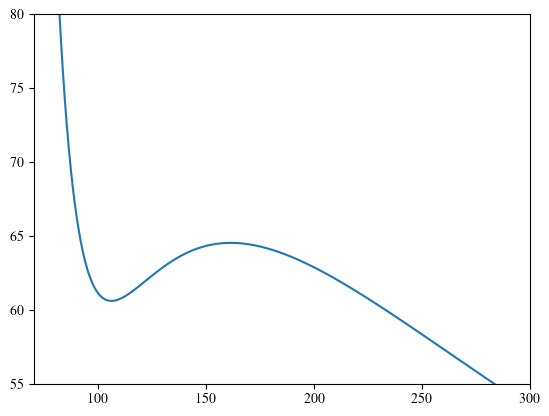

In [9558]:
fig, ax = plt.subplots(dpi=100)
plt.plot(V, p)
ax.set_xlim(70, 300)
ax.set_ylim(55, 80)


## Gemessene Isothermen

In [9559]:
file_path1 = '/Users/danielmiksch/Downloads/C31/C31_30_8.csv'
file_path2 = '/Users/danielmiksch/Downloads/C31/C31_35_8.csv'
file_path3 = '/Users/danielmiksch/Downloads/C31/C31_40_8.csv'
file_path4 = '/Users/danielmiksch/Downloads/C31/C31_43_2.csv'
file_path5 = '/Users/danielmiksch/Downloads/C31/C31_44_1.csv'
file_path6 = '/Users/danielmiksch/Downloads/C31/C31_45_1.csv'
file_path7 = '/Users/danielmiksch/Downloads/C31/C31_46_1.csv'
file_path8 = '/Users/danielmiksch/Downloads/C31/C31_47_0.csv'
file_path9 = '/Users/danielmiksch/Downloads/C31/C31_49_0.csv'
file_path10 = '/Users/danielmiksch/Downloads/C31/C31_50_0.csv'

data_30_8 = pd.read_csv(file_path1, sep=',')
data_35_8 = pd.read_csv(file_path2, sep=',')
data_40_8 = pd.read_csv(file_path3, sep=',')
data_43_2 = pd.read_csv(file_path4, sep=',')
data_44_1 = pd.read_csv(file_path5, sep=',')
data_45_1 = pd.read_csv(file_path6, sep=',')
data_46_1 = pd.read_csv(file_path7, sep=',')
data_47_0 = pd.read_csv(file_path8, sep=',')
data_49_0 = pd.read_csv(file_path9, sep=',')
data_50_0 = pd.read_csv(file_path10, sep=',')

In [9560]:
def error_array(array, sx, sy):
    err_x = np.full((len(array), 1), sx)
    err_y = np.full((len(array), 1), sy)
    return np.hstack((array, err_x, err_y))

In [9561]:
dV = 0.025
dP = 0.2

In [9562]:
a_SF6 = 7.857e-1
b_SF6 = 8.79e-5
x = np.linspace(.1, 5, 10000)

In [9563]:
# def isotherm(V, T):
#     return (((R*(T+273.15))/(V * 1e-6 -b_SF6))-(a_SF6/((V*1e-6)**2))) * 1e-5

In [9564]:
np.set_printoptions(suppress=True, precision=10)
data_30_8 = error_array(data_30_8.to_numpy(), dV, dP)
data_35_8 = error_array(data_35_8.to_numpy(), dV, dP)
data_40_8 = error_array(data_40_8.to_numpy(), dV, dP)
data_43_2 = error_array(data_43_2.to_numpy(), dV, dP)
data_44_1 = error_array(data_44_1.to_numpy(), dV, dP)
data_45_1 = error_array(data_45_1.to_numpy(), dV, dP)
data_46_1 = error_array(data_46_1.to_numpy(), dV, dP)
data_47_0 = error_array(data_47_0.to_numpy(), dV, dP)
data_49_0 = error_array(data_49_0.to_numpy(), dV, dP)
data_50_0 = error_array(data_50_0.to_numpy(), dV, dP)
# data_43_0 = data_43_0.to_numpy()

data_list = [['orange', data_30_8, 'T=30,8°C'],
             ['red', data_35_8, 'T=35,8°C'],
             ['fuchsia', data_40_8, 'T=40,8°C'],
             ['blue', data_43_2, 'T=43,2°C'],
             ['dodgerblue', data_44_1, 'T=44,1°C'],
             ['mediumturquoise', data_45_1, 'T=45,1°C'],
             ['green', data_46_1, 'T=46,1°C'],
             ['olive', data_47_0, 'T=47,0C'],
             ['gray', data_49_0, 'T=49,0°C'],
             ['black', data_50_0, 'T=50,0°C']]

In [9565]:
def maxwell_tie_line(data, threshold, data_range, end=None, print=True):
    x = data[:,0]
    y = data[:,1]
    sx = data[:,2]
    sy = data[:,3]
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    sx = sx[sorted_indices]
    sy = sy[sorted_indices]
    x_plot = np.linspace(0.25, 3, 10000)
    dy_dx = np.gradient(y, x)
    # index_array = np.where(dy_dx>-threshold)[0]
    x_coex = x[data_range[0]:data_range[1] + 1]
    sx_coex = sx[data_range[0]:data_range[1] + 1]
    x_sat = x[:data_range[0]]
    sx_sat = sx[:data_range[0]]
    if end is not None:
        x_lin = x[data_range[1] + 1:end + 1]
        sx_lin = sx[data_range[1] + 1:end + 1]
    else:
        x_lin = x[data_range[1] + 1:]
        sx_lin = sx[data_range[1] + 1:]
    y_coex = y[data_range[0]:data_range[1] + 1]
    sy_coex = sy[data_range[0]:data_range[1] + 1]
    y_sat = y[:data_range[0]]
    sy_sat = sy[:data_range[0]]
    if end is not None:
        y_lin = y[data_range[1] + 1:end + 1]
        sy_lin = sy[data_range[1] + 1:end + 1]
    else:
        y_lin = y[data_range[1] + 1:]
        sy_lin = sy[data_range[1] + 1:]
    beta_array = np.empty((0,2))
    def model_sat_lin(p, x):
        a, b = p
        return a*x+b
    model = Model(model_sat_lin)
    for i in [[x_lin, y_lin, sx_lin, sy_lin], [x_sat, y_sat, sx_sat, sy_sat]]:
        data_fit = RealData(i[0], i[1], sx=i[2], sy=i[3])
        odr = ODR(data_fit, model, beta0=[3, 1])
        output = odr.run()
        # output.pprint()
        beta_array = np.vstack((beta_array, output.beta))
    def model_coex(p, x):
        b = p
        return 0*x+b
    model = Model(model_coex)
    data_fit = RealData(x_coex, y_coex, sx=sx_coex, sy=sy_coex)
    odr = ODR(data_fit, model, beta0=[20])
    output = odr.run()
    # output.pprint()
    beta_array = np.vstack((beta_array, [0, output.beta[0]]))
    
    def intersection_points(betas): #betas as list
        points = np.empty((0,2))
        i = 0
        while i < 2:
            x = abs((betas[2][1] - betas[i][1]) / (betas[2][0] - betas[i][0]))
            y = model_sat_lin(betas[i], x)
            i += 1
            points = np.vstack((points, [x, y]))
        return points
    
    # print(beta_array)
    if print is True:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
        ax1.scatter(x_coex, y_coex, zorder=3, c='blue', s=4, edgecolors='none')
        ax1.scatter(x_lin, y_lin, zorder=3, c='orange', s=4, edgecolors='none')
        ax1.scatter(x_sat, y_sat, zorder=3, c='green', s=4, edgecolors='none')
        ax1.scatter(x, y, c='red', s=4, edgecolors='none')
        ax1.plot(x_plot, model_sat_lin(beta_array[0], x_plot), c='orange', linewidth=.5)
        ax1.plot(x_plot, model_sat_lin(beta_array[1], x_plot), c='green', linewidth=.5)
        ax1.plot(x_plot, model_sat_lin(beta_array[2], x_plot), c='blue', linewidth=.5)
        ax1.set_ylim(15, 40)
        # ax.set_xlim(0, 3.2)
        ax2.scatter(x, dy_dx)
        ax2.scatter(x[dy_dx>-threshold], dy_dx[dy_dx>-threshold])
    
    return intersection_points(beta_array)    

array([[ 0.9107142857, 34.7         ],
       [ 0.514988172 , 34.7         ]])

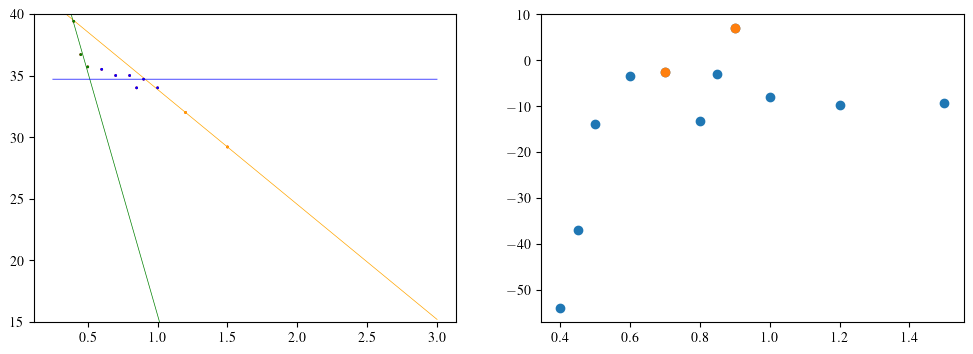

In [9566]:
point_list = np.empty((0,2))

point_list = np.vstack((point_list, maxwell_tie_line(data_30_8, 3, [4, 13], end=19, print=False)))
point_list = np.vstack((point_list, maxwell_tie_line(data_35_8, 3, [3, 10], end=None, print=False)))
point_list = np.vstack((point_list, maxwell_tie_line(data_40_8, 3, [4, 12], end=None, print=False)))
point_list = np.vstack((point_list, maxwell_tie_line(data_43_2, 3, [2, 7], end=None, print=False)))
point_list = np.vstack((point_list, maxwell_tie_line(data_44_1, 3, [3, 8], end=None, print=False)))


maxwell_tie_line(data_45_1, 3, [3, 8], end=None, print=True)

In [9567]:
# def isotherm_fit(x, nu, T):
#     # nu_fit  = p
#     return nu*(R*T*(x*1e-6)**2 - (x*1e-6)*a_SF6*nu + a_SF6*b_SF6*nu**2)/((x*1e-6)**2*((x*1e-6) - b_SF6*nu)) * 1e-5

In [9568]:
# popt, pcov = curve_fit(isotherm_fit, data_30_8[:,0], data_30_8[:,1], sigma=data_30_8[:,3], absolute_sigma=True, p0=[3, 310])
# popt

In [9569]:
def binodal_model(x, p0, A, V0, t1, t2):
    return p0+A*((1-np.exp(-(x-V0)/t1))*np.exp(-(x-V0)/t2))

In [9570]:
sorted_indices = np.argsort(point_list[:,0])
x_points = point_list[:,0][sorted_indices]
y_points = point_list[:,1][sorted_indices]

popt_binodal, pcov_binodal = curve_fit(binodal_model, x_points, y_points, p0=[0, 10000, .5, 11, .2])
# plt.plot(x, binodal_model(x,0, 100, 1, .5, 1, 1.5))

In [9571]:
maximum = minimize_scalar(lambda x: -binodal_model(x, popt_binodal[0], popt_binodal[1], popt_binodal[2], popt_binodal[3], popt_binodal[4]))
x_maximum = maximum.x
y_maximum = binodal_model(x_maximum, popt_binodal[0], popt_binodal[1], popt_binodal[2], popt_binodal[3], popt_binodal[4])

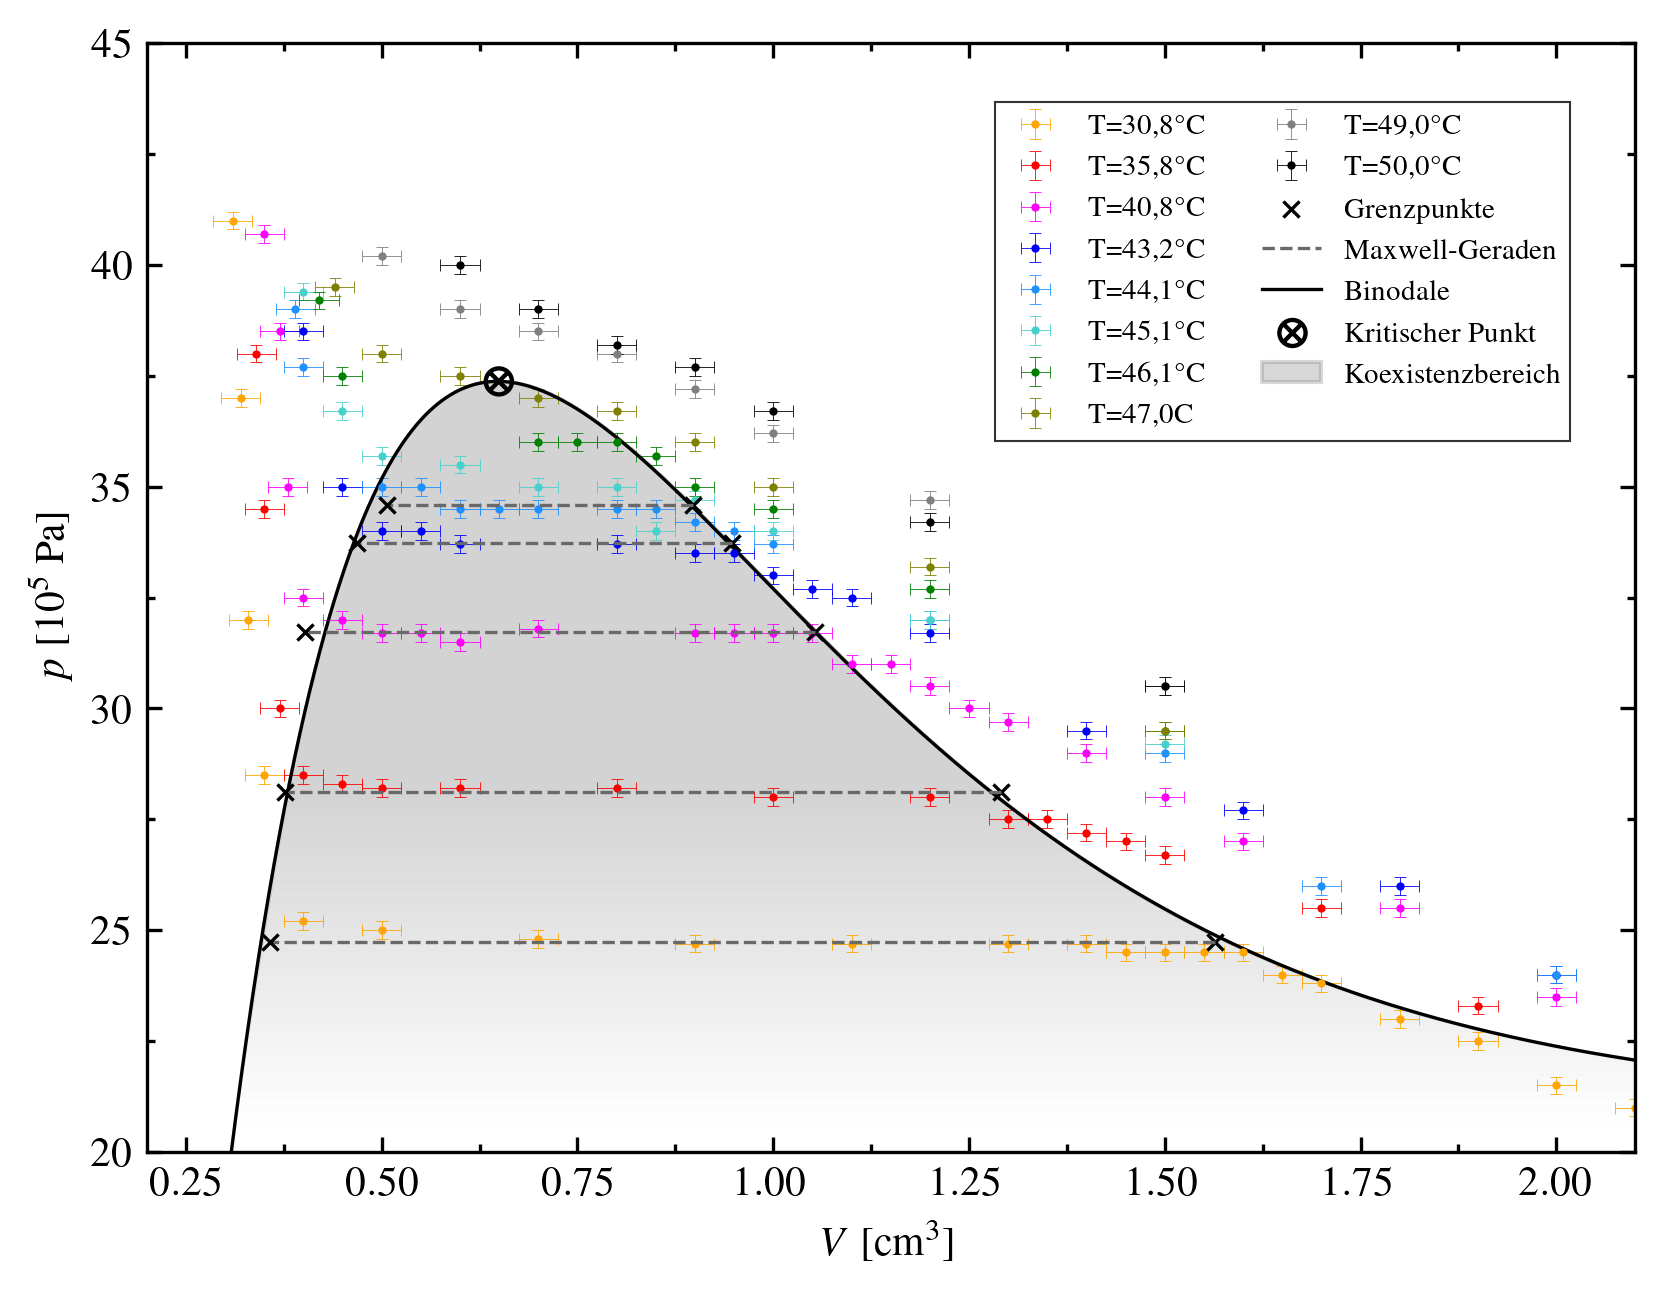

In [9572]:
import matplotlib.patches as patches

fig, ax = plt.subplots(dpi=300)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(0, 5, 10000)
#unbedingt Ticks an allen Seiten der Achsen

ax.set_xlim(.2, 2.1)
ax.set_ylim(20, 45)

for index, point in enumerate(point_list):
    ax.scatter(point[0], point[1], marker='x', 
           s=15,
           color='black',
           linewidth=.8,
           zorder=3)
    if (index + 1 < len(point_list)) & ((index % 2) == 0):
        next_point = point_list[index + 1]
        ax.plot([point[0], next_point[0]], [point[1], next_point[1]], color='dimgrey', linestyle='--', linewidth=.8, zorder=3)
        
ax.scatter(100, 100, marker='x', 
           s=15,
           color='black',
           label='Grenzpunkte',
           linewidth=.8,
           zorder=3)

ax.plot([200, 200], [400, 400], color='dimgrey', linestyle='--', label='Maxwell-Geraden', linewidth=.8, zorder=3)

for color, data, label in data_list:
    ax.errorbar(data[:,0], data[:,1],
                xerr=data[:,2], yerr=data[:,3],
                capsize=1.5, ecolor=color, elinewidth=0.2, capthick=0.2,
                markersize=4, fmt=".", markeredgecolor='none', c=color,
                zorder=2,
                label=label)

y1 = binodal_model(x, popt_binodal[0], popt_binodal[1], popt_binodal[2], popt_binodal[3], popt_binodal[4])

ax.plot(x, y1,
        c='black',
        linewidth=.8,
        label='Binodale',
        zorder=2)

ax.scatter([x_maximum], [y_maximum], marker="$\otimes$", 
           s=50,
           edgecolors='black',
           linewidth=.8,
           facecolors='none',
           label='Kritischer Punkt',
           zorder=3)

y_min = 20  # Sie können dies an Ihre Daten anpassen
y_max = max(y1)

num_bands = 100  # Erhöhen Sie die Anzahl der Streifen für einen feineren Verlauf

for i in range(num_bands):
    y_alpha_bottom = y_min + (y_max - y_min) * i / num_bands
    y_alpha_top = y_min + (y_max - y_min) * (i + 1) / num_bands
    alpha_val = 0.05 * (i / num_bands)
    ax.fill_between(x, y1, y_alpha_bottom, where=(y1 >= y_alpha_bottom), color='lightgray', alpha=alpha_val)
    
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='minor',direction='in', labelsize=10, width=.8, length=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(which='major',direction='in', labelsize=10, width=.8, bottom=True, top=True, left=True, right=True)

for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_linewidth(0.8)
    
ax.set_ylabel('$p$ [$10^5$ Pa]')
ax.set_xlabel(r'$V$ [$\mathrm{cm}^3$]')
    
gray_patch = patches.Patch(color='gray', alpha=0.3, label='Koexistenzbereich')
ax.legend(handles=[gray_patch])    

handles_ax, labels_ax = ax.get_legend_handles_labels()

handles_ax.append(gray_patch)
labels_ax.append('Koexistenzbereich')

handles = handles_ax 
labels = labels_ax

order = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13,  0, 1, 2, 3, 14]  # Beachten Sie, dass dies an Ihre spezifische Situation angepasst werden muss

legend = ax.legend([handles[idx] for idx in order],
          [labels[idx] for idx in order],
          loc="upper left",
          bbox_to_anchor=(0.56, 0.96),
          fancybox=False,
          edgecolor='black',
          fontsize=7,
          ncol=2)
legend.get_frame().set_linewidth(.5)

## Bestimmung kritischer Temperatur

In [9573]:
temps = [30.8, 35.8, 40.8, 43.2, 44.1]
dT = .1
temps = np.array([ufloat(i, dT) for i in temps]) + 273.15
inverse_temps = 1 / temps
inverse_temps = np.array([[unumpy.nominal_values(i) for i in inverse_temps], [unumpy.std_devs(i) for i in inverse_temps]])
print(inverse_temps)

pressure = point_list[:,1][::2]
pressure = np.array([ufloat(i, dP) for i in pressure])
pressure = np.array([log(i) for i in pressure])
pressure = np.array([[unumpy.nominal_values(i) for i in pressure], [unumpy.std_devs(i) for i in pressure]])
print(pressure[0])

[[0.0032900148 0.0032367697 0.0031852206 0.0031610558 0.0031520883]
 [0.0000010824 0.0000010477 0.0000010146 0.0000009992 0.0000009936]]
[3.2080170815 3.3362143173 3.4570174518 3.5184864682 3.5433718704]


In [9574]:
def model_lin(p, x):
    a, b = p
    return a*x+b

In [9575]:
def lin(x, a, b):
    return a*x+b

In [9576]:
popt, pcov = curve_fit(lin, inverse_temps[0], pressure[0], sigma=pressure[1], absolute_sigma=True)
popt

array([-2420.3963768625,    11.1700427323])

In [9577]:
model = Model(model_lin)
data = RealData(inverse_temps[0], pressure[0], sx=inverse_temps[1], sy=pressure[1])
odr = ODR(data, model, beta0=[1, 0.0])

output = odr.run()
output.pprint()

Beta: [-2420.02458994      11.1688525241]
Beta Std Error: [26.1279904905  0.083465716 ]
Beta Covariance: [[4298.2897312102  -13.7293436759]
 [ -13.7293436759    0.0438631598]]
Residual Variance: 0.15882407416894834
Inverse Condition #: 0.0004605454027594281
Reason(s) for Halting:
  Sum of squares convergence


### Kritische Temperatur / Druck

In [9578]:
p_crit = log(ufloat(y_maximum, 0.5))
a_crit = ufloat(output.beta[0], np.sqrt(output.cov_beta[0][0]))
b_crit = ufloat(output.beta[1], np.sqrt(output.cov_beta[1][1]))
V_crit = ufloat(maximum.x, 0.050)

T = a_crit / (p_crit - b_crit)
print(f"TK = {T-273.15} °C")
print(f"pK = {p_crit} 10^5 Pa")
print(f"VK = {V_crit} cm^3")
V_crit

TK = 47+/-12 °C
pK = 3.621+/-0.013 10^5 Pa
VK = 0.65+/-0.05 cm^3


0.6482614641071344+/-0.05

In [9579]:
x_crit = 1 / unumpy.nominal_values(T)
y_crit = unumpy.nominal_values(p_crit)

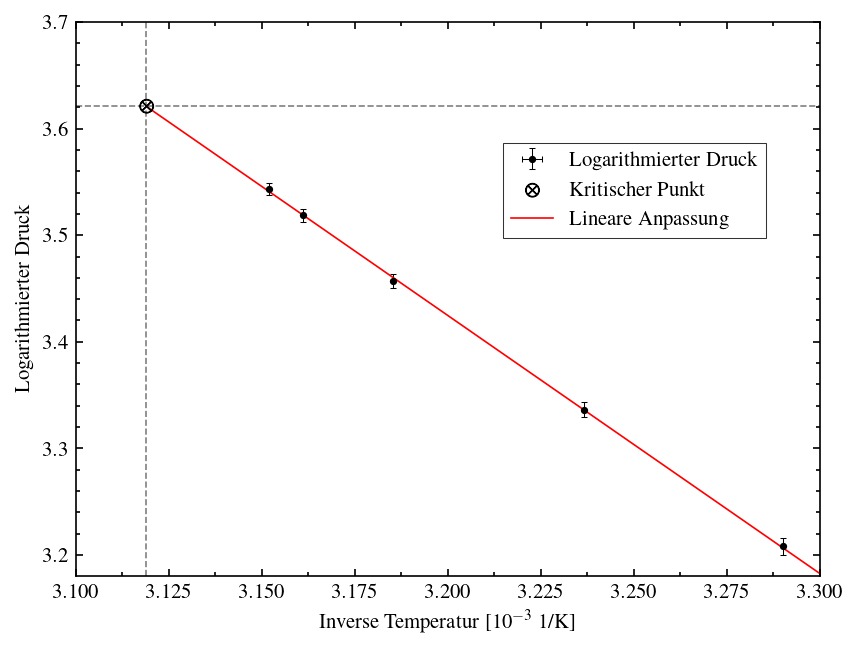

In [9580]:
fig, ax = plt.subplots(dpi=150)

x = np.linspace(x_crit, 1, 1000)

ax.errorbar(inverse_temps[0] * 1000, pressure[0],
                xerr=inverse_temps[1], yerr=pressure[1],
                capsize=1.5, ecolor='black', elinewidth=0.5, capthick=0.5,
                markersize=7, fmt=".", markeredgecolor='none', c='black',
                zorder=2,
                label='Logarithmierter Druck')

ax.plot(x * 1000, model_lin(output.beta, x),
        c='red',
        linewidth=.8,
        label='Lineare Anpassung',
        zorder=2)

ax.scatter([x_crit * 1000], [y_crit], marker="$\otimes$", 
           s=50,
           edgecolors='black',
           linewidth=.6,
           facecolors='none',
           label='Kritischer Punkt',
           zorder=3)

ax.axvline(x_crit * 1000,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=1)
ax.axhline(y_crit,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=1)
# 
ax.set_xlim(3.1, 3.3)
ax.set_ylim(3.18, 3.7)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor',direction='in', labelsize=10, width=.8, length=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(which='major',direction='in', labelsize=10, width=.8, bottom=True, top=True, left=True, right=True)

ax.set_ylabel('Logarithmierter Druck')
ax.set_xlabel(r'Inverse Temperatur [$10^{-3}$ 1/K]')

handles_ax, labels_ax = ax.get_legend_handles_labels()

handles = handles_ax 
labels = labels_ax

order = [2, 1, 0]

legend = ax.legend([handles[idx] for idx in order],
          [labels[idx] for idx in order],
          loc="upper left",
          bbox_to_anchor=(0.56, 0.8),
          fancybox=False,
          edgecolor='black',
          fontsize=10)

legend.get_frame().set_linewidth(.5)


### Verdampfungsentalpie

In [9581]:
HV = -constants.R * a_crit
HV / 1000 #in kJ/mol

20.121203987696912+/-0.5451073377943512

In [9582]:
data_50_0

array([[ 1.5  , 30.5  ,  0.025,  0.2  ],
       [ 1.2  , 34.2  ,  0.025,  0.2  ],
       [ 1.   , 36.7  ,  0.025,  0.2  ],
       [ 0.9  , 37.7  ,  0.025,  0.2  ],
       [ 0.8  , 38.2  ,  0.025,  0.2  ],
       [ 0.7  , 39.   ,  0.025,  0.2  ],
       [ 0.6  , 40.   ,  0.025,  0.2  ]])

In [9583]:
V = np.array([ufloat(i[0], dV) for  i in data_50_0])
V_inverse = 1 / V
V_inverse = np.array([[unumpy.nominal_values(i) for i in V_inverse], [unumpy.std_devs(i) for i in V_inverse]])
pV = np.array([(ufloat(i[0], dV)*ufloat(i[1], dP)) for i in data_50_0])*1e-1
pV = np.array([[unumpy.nominal_values(i) for i in pV], [unumpy.std_devs(i) for i in pV]])

In [9584]:
popt_aos, pcov_aos = curve_fit(lin, V_inverse[0][:4], pV[0][:4], sigma=pV[1][:4], absolute_sigma=True)
a_aos, b_aos = popt_aos

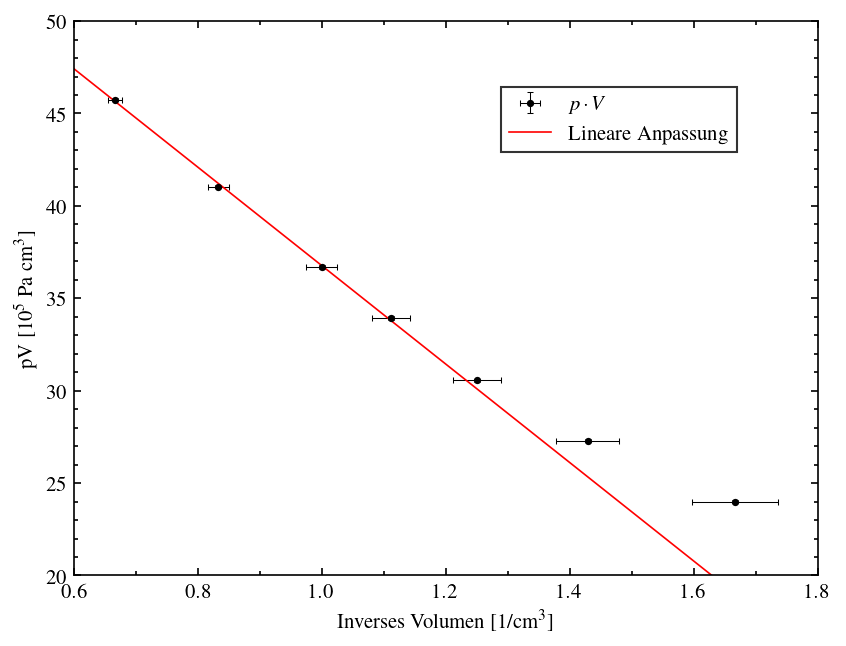

In [9585]:
fig, ax = plt.subplots(dpi=150)

x = np.linspace(0, 4, 1000)

ax.errorbar(V_inverse[0], pV[0] * 10,
                xerr=V_inverse[1], yerr=pV[1],
                capsize=1.5, ecolor='black', elinewidth=0.5, capthick=0.5,
                markersize=7, fmt=".", markeredgecolor='none', c='black',
                zorder=2,
                label='$p\cdot V$')

ax.plot(x, lin(x, a_aos, b_aos) * 10,
        c='red',
        linewidth=.8,
        label='Lineare Anpassung',
        zorder=2)
# 
# ax.scatter([x_crit * 1000], [y_crit], marker="$\otimes$", 
#            s=50,
#            edgecolors='black',
#            linewidth=.6,
#            facecolors='none',
#            label='Kritischer Punkt',
#            zorder=3)

# ax.axvline(x_crit * 1000,
#            color='grey',
#            linestyle='--',
#            linewidth=0.8,
#            zorder=1)
# ax.axhline(y_crit,
#            color='grey',
#            linestyle='--',
#            linewidth=0.8,
#            zorder=1)
# # 
ax.set_xlim(0.6, 1.8)
ax.set_ylim(20, 50)
# 
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor',direction='in', labelsize=10, width=.8, length=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(which='major',direction='in', labelsize=10, width=.8, bottom=True, top=True, left=True, right=True)
# 
ax.set_ylabel('pV [$10^5$ Pa cm$^3$]')
ax.set_xlabel(r'Inverses Volumen [1/cm$^3$]')
# 
handles_ax, labels_ax = ax.get_legend_handles_labels()

handles = handles_ax 
labels = labels_ax

order = [1, 0]

legend = ax.legend([handles[idx] for idx in order],
          [labels[idx] for idx in order],
          loc="upper left",
          bbox_to_anchor=(0.56, 0.9),
          fancybox=False,
          edgecolor='black',
          fontsize=10)
# 
# legend.get_frame().set_linewidth(.5)

### Bestimmung der Stoffmenge / kritische Dichte

In [9586]:
b_aos = ufloat(b_aos, np.sqrt(pcov_aos[1][1]))
nu = b_aos / (constants.R * (50.0 + 273.15))
nu * 1000 #in 10^-3 mol

2.36016925741465+/-0.08784997374417167

In [9587]:
mol_m = 146.05
rho_crit = (nu * mol_m) / V_crit
rho_crit

0.5317340905342518+/-0.04553832849506948

In [9588]:
nu_2 = 0.735 * (V_crit / mol_m)
nu_2 * 1000

3.2623907984850646+/-0.2516261554262239

### Van der Waals-Konstanten

In [9589]:
a_w = (27 * R**2 * T**2) / (64 * (p_crit**2)*1e5)
a_w

2.286612722450063+/-0.17756563409924983